# Create a PowerPoint from Satellite Course Slides on ERDDAP

> History | Updated Mar 2025

## Introduction

This tutorial shows how to **retrieve Satellite Course Slide data from a private ERDDAP server**, process it in Jupyter Notebook, and **generate a PowerPoint presentation**.

## Resources

In order to run this tutorial, you will need:

- Python 3

- Jupyter Notebook

- Internet Connection

- Microsoft PowerPoint

## Load Required Packages

In [ ]:
import os
import requests
import subprocess
import urllib
import pandas as pd
from io import BytesIO
from pptx import Presentation
from pptx.util import Inches, Pt
from PIL import Image
import time
import pickle  # To store/reuse cookies
import concurrent.futures  # For parallel downloads
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
ChromeDriverManager().install()
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.chrome.options import Options

## Make Some Useful Functions

def get_browser_cookies(url):
    """
    Retrieve cookies from the browser using Selenium.

    The function opens a Google Chrome browser, navigates to the
    specified login URL, and waits for the user to manually log in.
    Once logged in, it extracts cookies from the browser session
    and formats them into a string suitable for HTTP headers.

    Args:
        url (str): The login URL of the website requiring authentication.

    Returns:
        str: A formatted string containing cookies to be used in HTTP requests.

    Raises:
        ValueError: If no cookies are retrieved, possibly due to
        insufficient sleep time or an imcompatible/missing WebDriver.

    """

    # Set Chrome options to suppress automation messages
    chrome_options = Options()
    chrome_options.add_argument(
        "--disable-blink-features=AutomationControlled"
    )  # Disable automation message
    chrome_options.add_experimental_option(
        "excludeSwitches", ["enable-automation"]
    )  # Hide "Chrome is controlled" message
    chrome_options.add_experimental_option(
        "useAutomationExtension", False
    )  # Disable the default automation extension

    # Start the Chrome browser using webdriver-manager
    driver = webdriver.Chrome(
        service=ChromeService(ChromeDriverManager().install()),
        options=chrome_options,
    )

    try:
        # Navigate to the login page
        driver.get(url)

        # Wait for the user to complete login (adjust time as needed)
        time.sleep(60)

        # Retrieve cookies from the browser session
        cookies = driver.get_cookies()

        # Verify cookies were retrieved successfully
        if not cookies:
            raise ValueError(
                "No cookies retrieved. Possible causes:\n"
                "- Insufficient sleep time; try increasing the sleep duration.\n"
                "- Incompatible or missing WebDriver for Chrome."
            )

        # Format cookies for session headers
        formatted_cookies = "; ".join(
            [f"{cookie['name']}={cookie['value']}" for cookie in cookies]
        )
        print("Cookies Retrieved. Attempting to Access ERDDAP Dataset..")

    finally:
        # Close the browser
        driver.quit()

    return formatted_cookies

In [ ]:
def get_browser_cookies(url):
    chrome_options = Options()
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--headless")  # Needed in no-GUI Binder
    chrome_options.add_argument("--window-size=1920x1080")

    # Set Chrome binary location
    chrome_options.binary_location = "/usr/bin/chromium-browser"

    # Start virtual display for headless mode (important for Binder)
    xvfb_cmd = ['Xvfb', ':99', '-screen', '0', '1920x1080x24']
    proc = subprocess.Popen(xvfb_cmd)
    os.environ['DISPLAY'] = ':99'

    driver = webdriver.Chrome(
        service=ChromeService(ChromeDriverManager().install()),
        options=chrome_options
    )

    driver.get(url)
    print("Please log in manually in the browser window...")

    input("Press Enter after logging in...")

    cookies = driver.get_cookies()
    driver.quit()
    proc.terminate()

    cookie_header = "; ".join([f"{c['name']}={c['value']}" for c in cookies])
    return cookie_header

In [3]:
def authenticate_session(url):
    """
    Authenticate session and return the session object.

    The function intializes a `requests.Session` object
    and retrieves authentication cookies from the
    specified login URL using Selenium. The cookies
    are then added to the session headers, allowing
    susbequent HTTP requests to be made as an
    authenticated user.

    Args:
        url (str): The login URL requiring authentication.

    Returns:
        requests.Session: An authenticated session object with cookies set in the headers.

    Raises:
        ValueError: If no cookies are retrieved, the program exits with an error message.

    """
    session = requests.Session()

    # Get cookies from ERDDAP login page using Selenium
    try:
        cookie_header = get_browser_cookies(url)
    except ValueError as e:
        print(e)
        exit(1)

    # Set headers with cookies for authenticated requests
    session.headers.update(
        {"User-Agent": "Mozilla/5.0", "Cookie": cookie_header}
    )
    return session

In [4]:
def download_csv_with_auth(session, file_url):
    """
    Download and read CSV data using an authenticated session.

    The functions sends a GET request to the specified
    URL using the provided authenticated session. If the request
    is successful (HTTP 200), the response content is read into
    a Pandas Dataframe.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        file_url (str): The URL of the CSV file to be downloaded.

    Returns:
        pandas.DataFrame: A DataFrame containing the CSV data if the request is successful.
        None: If the request fails.

    """
    response = session.get(file_url)

    if response.status_code == 200:
        print("Successfully retrieved ERDDAP CSV data")
        data = pd.read_csv(BytesIO(response.content), header = 0, skiprows=[1])
        return data
    else:
        print(f"Failed to retrieve data. Status Code: {response.status_code}")

In [5]:
def download_image(session, image_url):
    """
    Download an image using an authenticated session.

    The function sends a GET request to the specified image
    URL using the provided authenticated session. If the request is successful (HTTP 200),
    the image content is returned as a BytesIO object.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        image_url (str): The URL of the image to be downloaded.


    Returns:
        BytesIO: A BytesIO object containing the image data if the request is successful.
        None: If the request fails.

    """
    response = session.get(image_url)
    if response.status_code == 200:
        return BytesIO(response.content)
    else:
        print(f"Failed to download image: {image_url}")
        return None

In [6]:
def parallel_download_images(session, slide_urls):
    """
    Download images in parallel using multithreading.

    The function uses a ThreadPoolExecutor to download
    multiple images in parallel, significantly reducing
    download time compared to sequential requests. Each
    image is fetched using the `download_image` function
    and stored in a dictionary.

    Args:
        session (requests.Session): An authenticated session object with necessary headers.
        slide_urls (list of str): A list of image URLs to be downloaded.


    Returns:
        dict: A dictionary where keys are image URLs and values are BytesIO objects
        containing the image data.

    """
    images = {}

    def fetch(url):
        img_data = download_image(session, url)
        if img_data:
            images[url] = img_data

    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        executor.map(fetch, slide_urls)

    return images

## ERDDAP Authentication
Login into ERDDAP with Google login to retrieve cookies.

In [7]:
# ERDDAP login URL (through Google login)
login_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/loginGoogle.html"
session = authenticate_session(login_url)

Cookies Retrieved. Attempting to Access ERDDAP Dataset..


## Download Metadata from ERDDAP

After you are logged into ERDDAP, navigate to the dataset: **satellite_course_slides_metadata**. Here is a screenshot to reference how to extract the CSV URL:

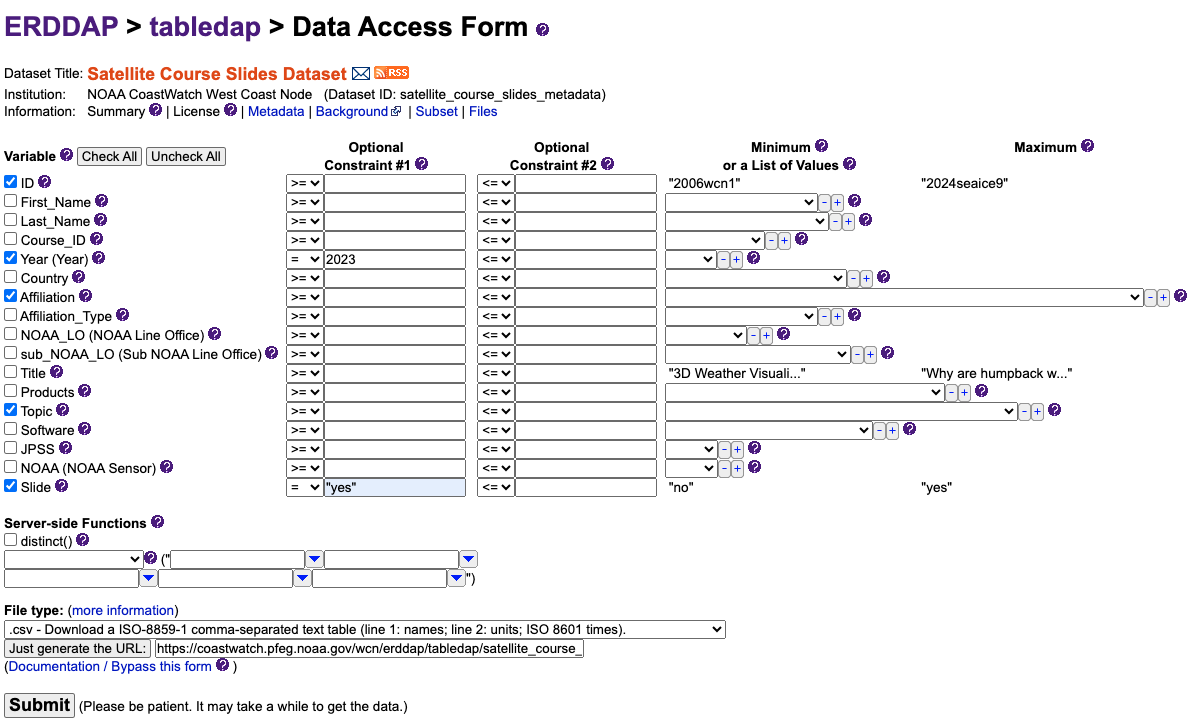

**ID** must always be selected because it is used to define the names of the pngs to be downloaded. Also, make sure that **Slide** is always set to "yes" to make sure you only recieve metadata from submitted slides.

Copy the CSV URL link and update the **metadata_url** below in order to make a PowerPoint presentation with the information you are interested in.

In [8]:
# ERDDAP metadata URL for satellite course slides
metadata_url = "https://coastwatch.pfeg.noaa.gov/wcn/erddap/tabledap/satellite_course_slides_metadata.csv?ID%2CYear%2CAffiliation%2CTopic%2CSlide&Year=2023&Slide=%22yes%22"

# Download metadata CSV using an authenticated session
metadata_df = download_csv_with_auth(session, metadata_url)

# Exit if the dataset could not be retrieved
if metadata_df is None:
    exit(1)

# Clean column names by stripping whitespace
metadata_df.columns = metadata_df.columns.str.strip()

# Display available columns
print("Columns in metadata dataset:", metadata_df.columns.tolist())

Successfully retrieved ERDDAP CSV data
Columns in metadata dataset: ['ID', 'Year', 'Affiliation', 'Topic', 'Slide']


# Prepare Metadata for PowerPoint Slides
Choose the columns from the metadata that you want used for a title for the powerpoint slides.

In [10]:
# Create a copy of the metadata DataFrame
selected_metadata = metadata_df.copy()

# Define columns to be used for slide titles
columns_for_title = ["Affiliation", "Topic"]

# Extract only the selected columns for PowerPoint text
metadata_for_ppt = selected_metadata[columns_for_title]

# Retrieve slide IDs for image lookup
selected_ids = selected_metadata["ID"].tolist()

# Print the selected slide IDs
print(f"Selected Metadata IDs: {selected_ids}")

Selected Metadata IDs: ['2023wcn3', '2023wcn8', '2023wcn9', '2023wcn1', '2023wcn10', '2023wcn13', '2023wcn15', '2023wcn14', '2023wcn6', '2023wcn16', '2023wcn18', '2023wcn21', '2023wcn4', '2023wcn19', '2023wcn12', '2023wcn17', '2023wcn11', '2023wcn2', '2023wcn20', '2023wcn7', '2023wcn5']


# Generate Slide Image URLs

Construct URLs for each slide image based on the slide IDs retrieved from the metadata.

In [11]:
# Base URL for accessing slide images
slide_base_url = (
    "https://coastwatch.pfeg.noaa.gov/wcn/erddap/files/course_slide_deck/"
)

# Generate full image URLs for each slide ID
slide_urls = [f"{slide_base_url}{slide_id}.png" for slide_id in selected_ids]

## Download Slide Images in Parallel

Download slides images concurrently to decrease run time. Takes around 3.5 minutes to download 20 slides.

In [12]:
# Download all images in parallel
images = parallel_download_images(session, slide_urls)

## Create a PowerPoint Presentation

In [13]:
prs = Presentation()
prs.slide_width = Inches(16)
prs.slide_height = Inches(9)

fixed_img_width = Inches(11)
fixed_img_height = Inches(6.0)
default_img_top = Inches(2.0)


for i, slide_id in enumerate(selected_metadata["ID"]):
    slide_url = f"{slide_base_url}{slide_id}.png"
    if slide_url not in images:
        continue  # Skip if image download failed

    img_data = images[slide_url]

    # Open Image with PIL to Resize Efficiently
    with Image.open(img_data) as img:
        orig_width, orig_height = img.size
        aspect_ratio = orig_width / orig_height

    blank_slide_layout = prs.slide_layouts[5]
    slide = prs.slides.add_slide(blank_slide_layout)

    # Construct Slide Title
    metadata_text = "\n".join(
        [
            f"{col}: {metadata_for_ppt[col].values[i]}"
            for col in metadata_for_ppt.columns
        ]
    )

    title_shape = slide.shapes.title
    if title_shape:
        title_shape.text_frame.clear()  # Clears any existing text to prevent duplication

        # Reposition title text box at the top
        title_shape.left = Inches(0.2)
        title_shape.top = Inches(0.2)  # Keep at top of slide
        title_shape.width = prs.slide_width - Inches(0.4)
        title_shape.height = Inches(1.2)  # Adjust text box height

        # Add text as a single paragraph
        paragraph = title_shape.text_frame.add_paragraph()
        paragraph.text = metadata_text

        # Ensure font size is uniform
        font_size = Pt(32) if len(metadata_text) < 300 else Pt(24)
        for run in paragraph.runs:
            run.font.size = font_size

    # Ensure image sizes are the same
    img_width = fixed_img_width
    img_height = fixed_img_height

    # Center the image properly
    left = (prs.slide_width - img_width) / 2  # Center the image

    # Reset the image data stream before inserting into PowerPoint
    img_data.seek(0)

    # Add image while keeping uniform size
    img = slide.shapes.add_picture(
        img_data, left, default_img_top, width=img_width, height=img_height
    )

## Save the PowerPoint File

Update **output_file** path to where you want the PowerPoint saved and change the name as well.

In [14]:
output_file = "/Users/madisonrichardson/slides/pptx/new_course_slides_py.pptx"
prs.save(output_file)
print(f"Presentation saved as {output_file}")

Presentation saved as /Users/madisonrichardson/slides/pptx/new_course_slides_py.pptx
